In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

from tensorflow.keras.models import load_model
from corner import corner

2023-07-31 16:18:34.523396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = "/mnt/data-storage/stellar-emulator/train/20230628-155230/best_model.tf"
tf_emulator = load_model(path)

In [3]:
weights = tf_emulator.get_weights()
offset = np.array(tf_emulator.layers[-1].offset)
scale = np.array(tf_emulator.layers[-1].scale)

def elu(x, alpha=1.0):
    return pt.where(x > 0.0, x, alpha*(pt.exp(x) - 1))

def emulator(x):
    x -= weights[0]
    x /= weights[1]**0.5
    for w, b in zip(weights[3:-2:2], weights[4:-1:2]):
        x = elu(pt.matmul(x, w) + b)
    x = pt.matmul(x, weights[-2]) + weights[-1]
    return offset + scale * x

In [4]:
log_zx_sun = np.log10(0.0181)
log_teff_sun = np.log10(5772)

def log_luminosity(log_teff, log_radius):
    return 2 * log_radius + 4 * (log_teff - log_teff_sun)

def hydrogen(y, z):
    return 1 - y - z

def metallicity(y, z):    
    return pt.math.log10(z / hydrogen(y, z)) - log_zx_sun

In [32]:
num_stars = 5
coords = {"star": np.arange(num_stars)}

with pm.Model(coords=coords) as model:
    _teff = pm.MutableData("Teff_obs", 5772.*np.ones(num_stars), dims="star")
    _lum = pm.MutableData("lum_obs", np.ones(num_stars), dims="star")
    _mh = pm.MutableData("[M/H]_obs", np.zeros(num_stars), dims="star")
    
    eep = pm.Uniform("EEP", 0.0, 4.0, dims="star")
    mass = pm.Uniform("mass", 0.75, 2.25, dims="star")
    y = pm.Uniform("Y", 0.225, 0.315, dims="star")
    log_z = pm.Uniform("log_Z", -2.7, -1.4, dims="star")
    z = pm.Deterministic("Z", 10**log_z, dims="star")
    mlt = pm.Uniform("a_MLT", 1.5, 2.5, dims="star")
    
    xx = pt.stack([eep, mass, y, log_z, mlt], axis=-1)
    yy = emulator(xx)

    log_age = pm.Deterministic("log_age", yy[:, 0], dims="star")
    age = pm.Deterministic("age", 10**log_age, dims="star")
    
    teff = pm.Normal("Teff", 10**yy[:, 1], 50.0, observed=_teff, dims="star")
    rad = pm.Deterministic("rad", 10**yy[:, 2], dims="star")
    
    log_lum = log_luminosity(yy[:, 1], yy[:, 2])
    lum = pm.Normal("lum", 10**log_lum, 0.01, observed=_lum, dims="star")
    
    mh = pm.Normal("[M/H]", metallicity(y, z), 0.05, observed=_mh, dims="star")
    
#     truth = pm.sample_prior_predictive(1, return_inferencedata=False, random_seed=0)
    data = pm.sample_prior_predictive(1000)

Sampling: [EEP, Teff, Y, [M/H], a_MLT, log_Z, lum, mass]


In [33]:
# truth = {k: v.squeeze() for k, v in truth.items()}
truth = {k: np.array([v]) for k, v in truth.items()}
truth

NameError: name 'truth' is not defined

In [34]:
data

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

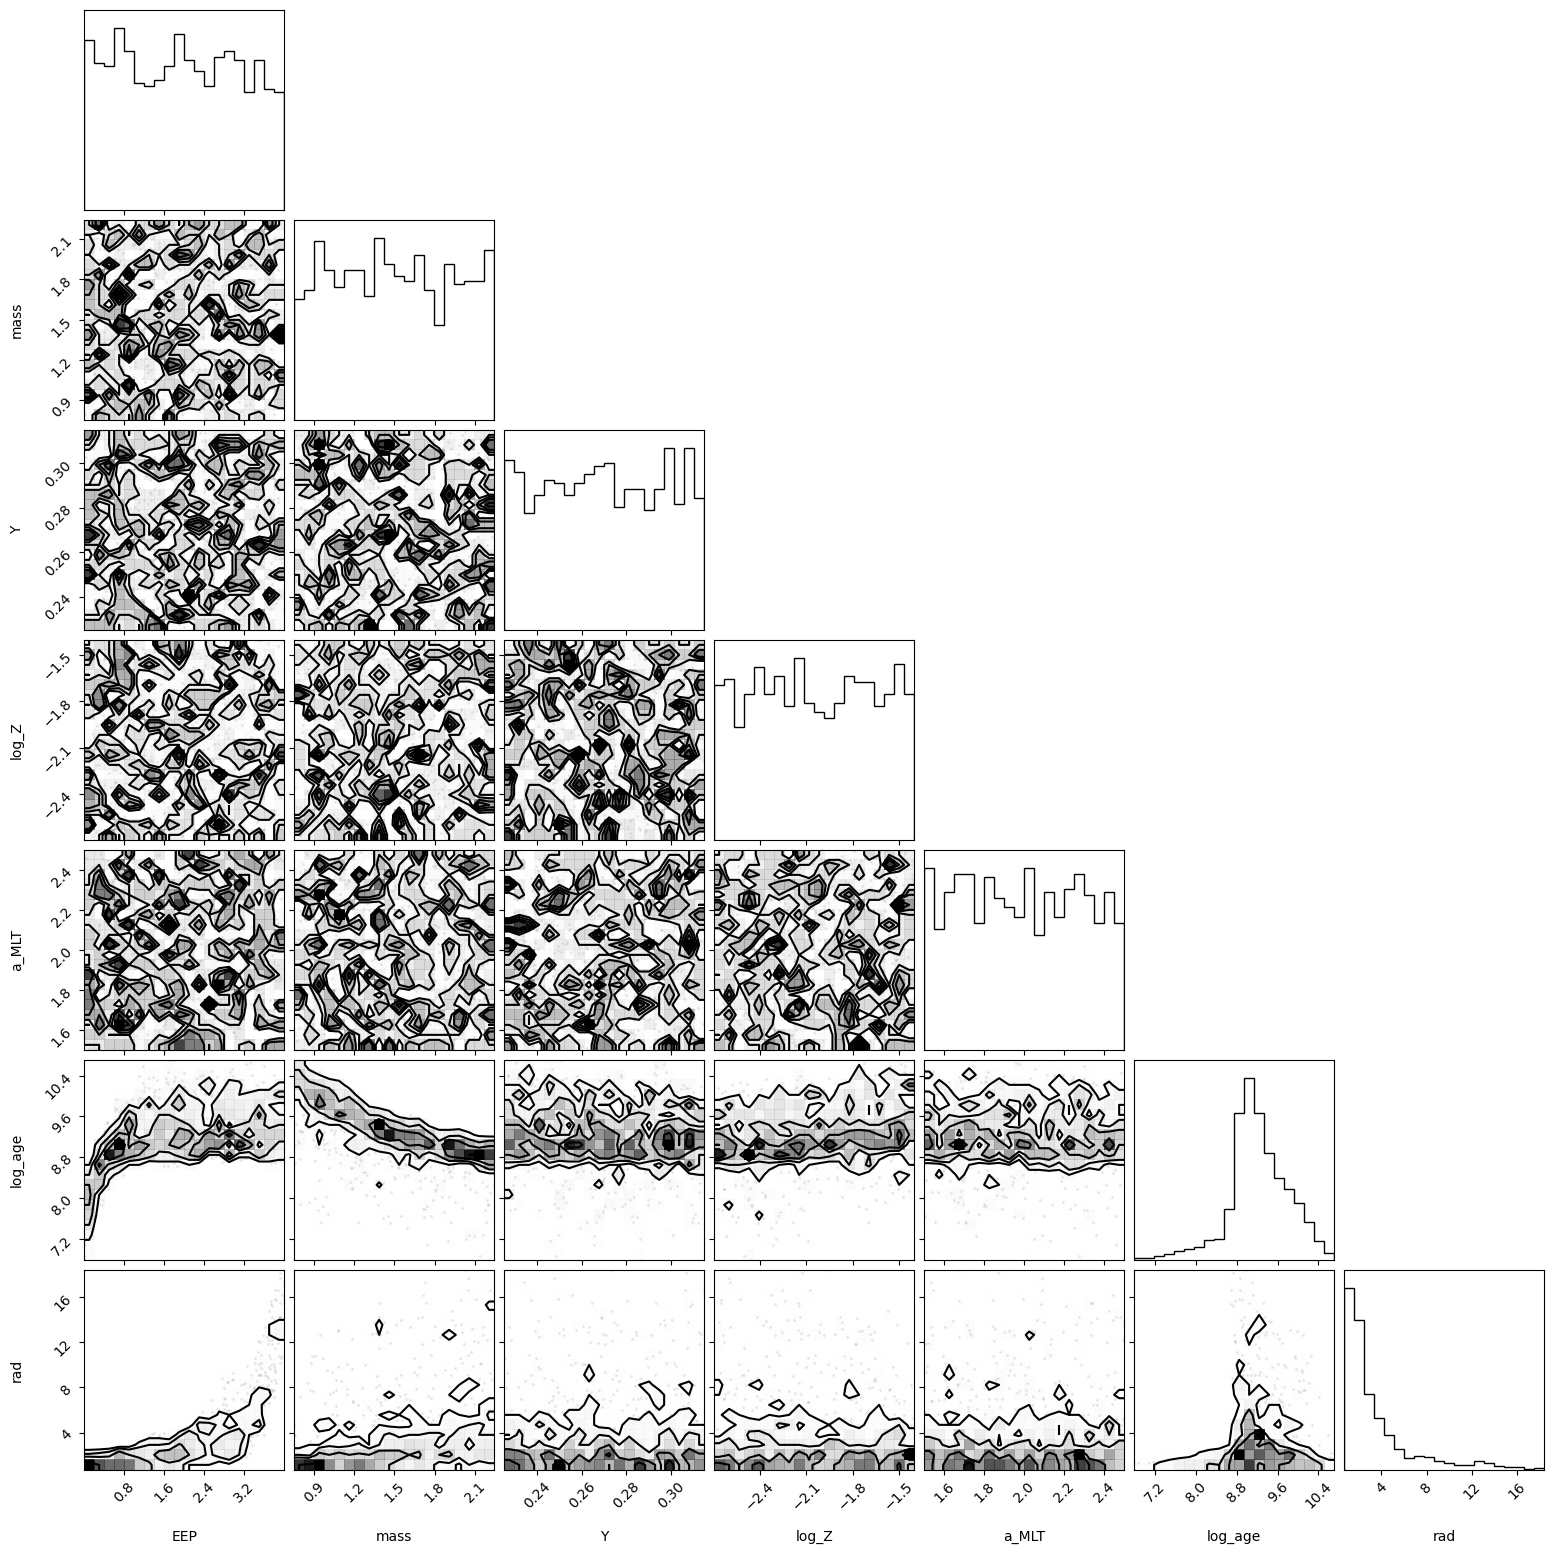

In [35]:
star = 0
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT", "log_age", "rad"]
# true_values = {k: v[star] for k, v in truth.items()}
true_values = None
fig = corner(data, group="prior", var_names=var_names, coords={"star": star}, truths=true_values)

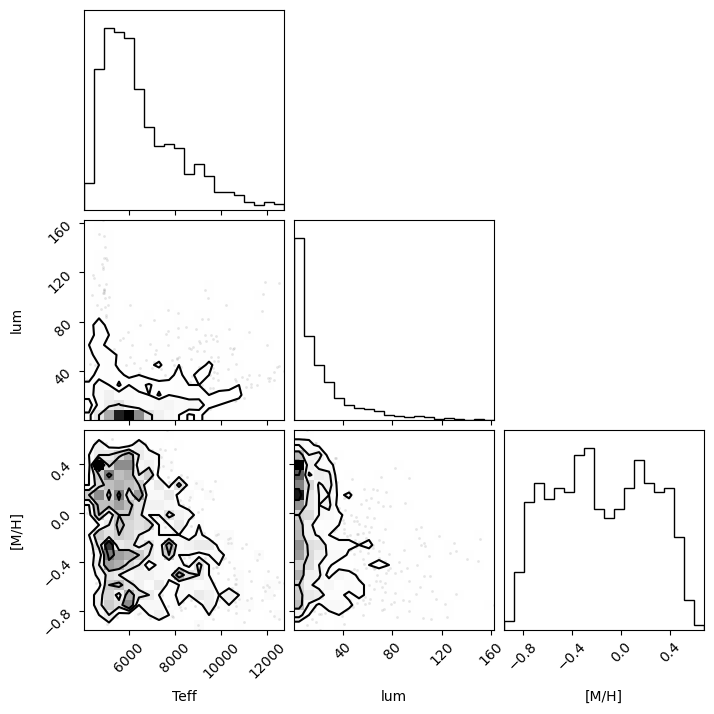

In [36]:
star = 0
var_names = ["Teff", "lum", "[M/H]"]
# true_values = {k: v[star] for k, v in truth.items()}
fig = corner(data, group="prior_predictive", var_names=var_names, coords={"star": star}, truths=true_values)

In [37]:
# obs = {
#     "Teff_obs": truth["Teff"],
#     "lum_obs": truth["lum"],
#     "[M/H]_obs": truth["[M/H]"],
# }

In [38]:
with model:
#     pm.set_data(obs)
    data.extend(pm.sample(random_seed=0, tune=2000, draws=2000))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [EEP]
>Metropolis: [mass]
>Metropolis: [Y]
>Metropolis: [log_Z]
>Metropolis: [a_MLT]


/home/alex/miniconda3/envs/pymc/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/alex/miniconda3/envs/pymc/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/alex/miniconda3/envs/pymc/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/alex/miniconda3/envs/pymc/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.o

In [39]:
with model:
    pm.sample_posterior_predictive(data, extend_inferencedata=True)

Sampling: [Teff, [M/H], lum]


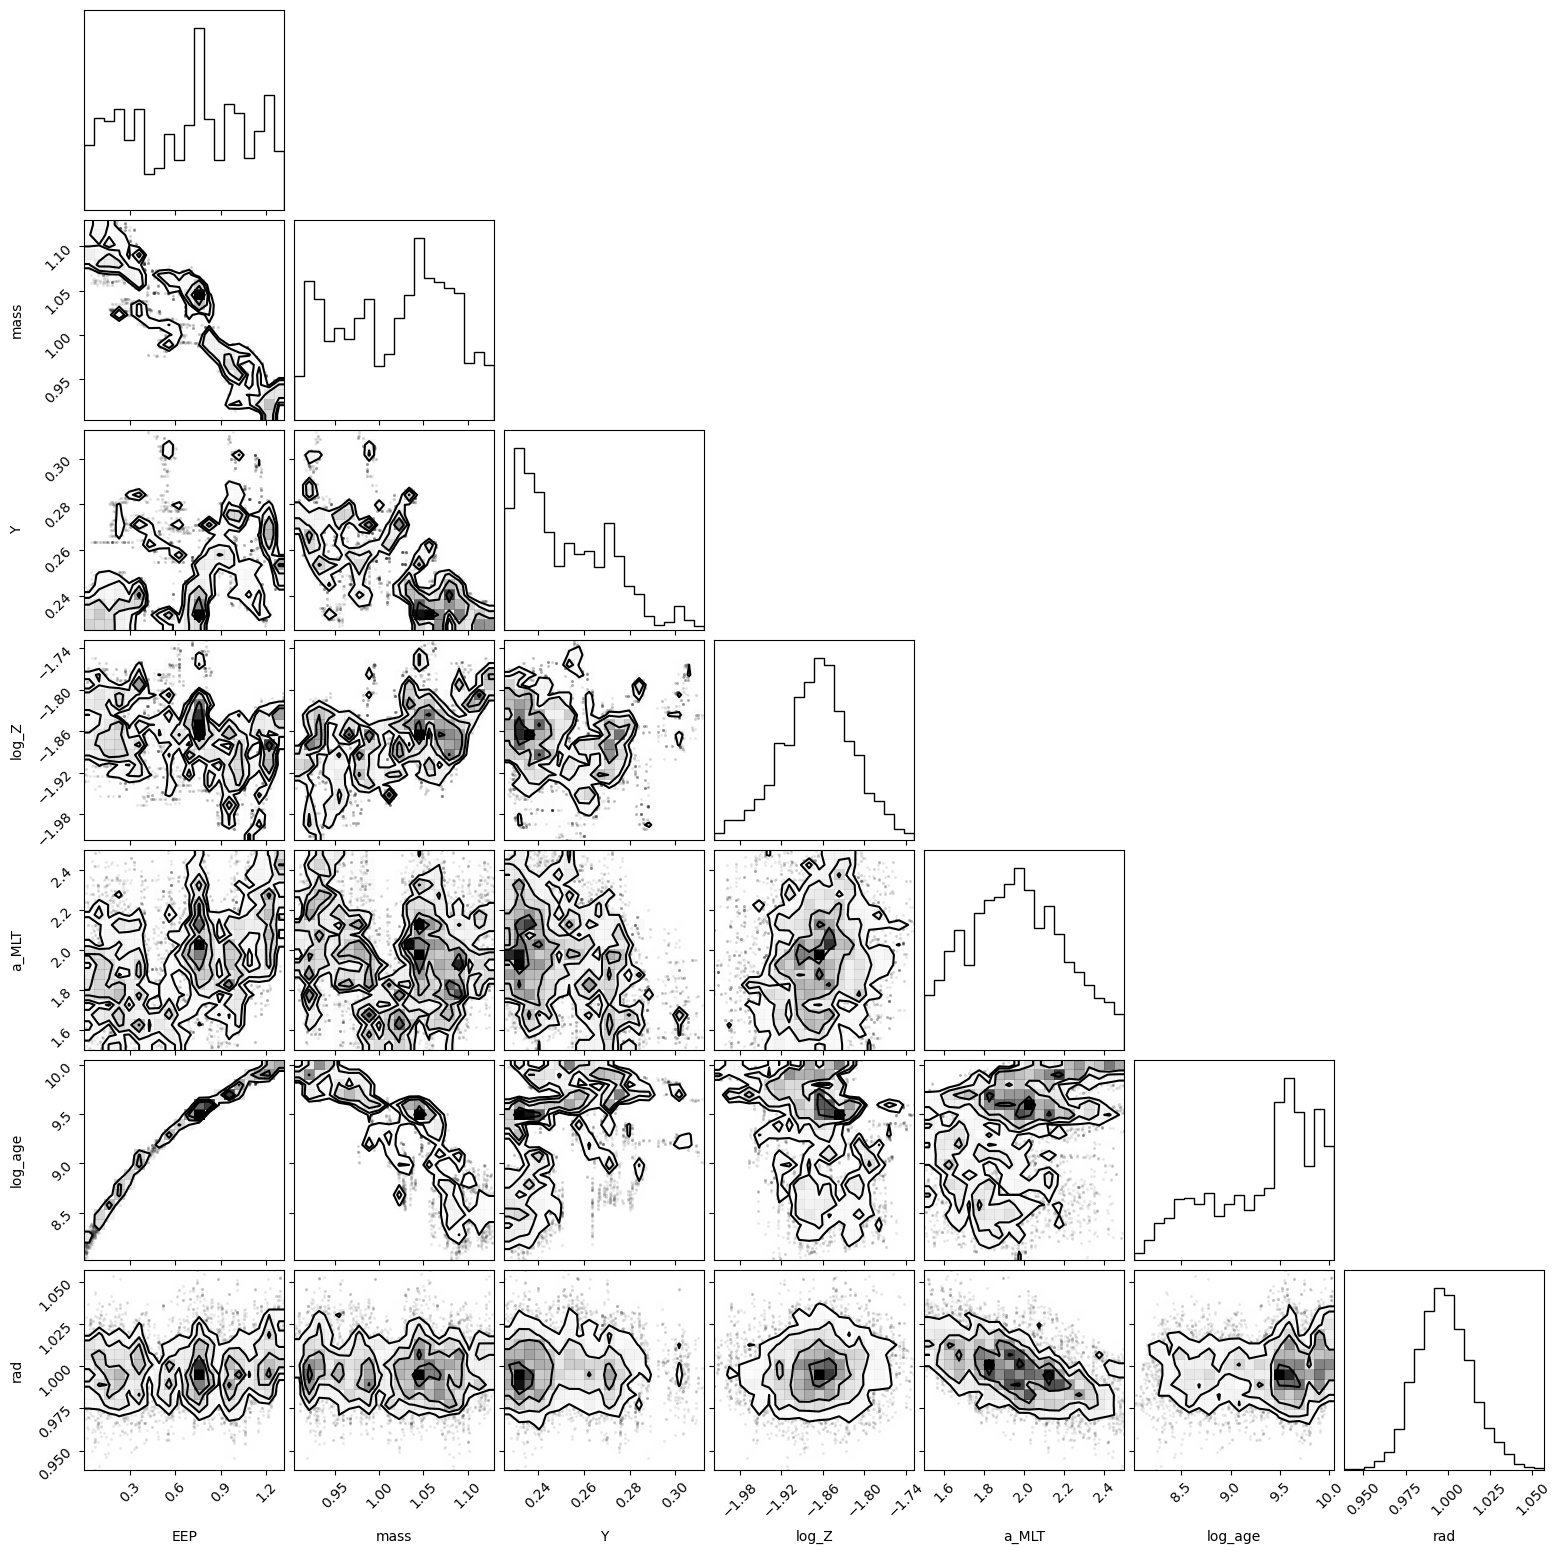

In [40]:
star = 0
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT", "log_age", "rad"]
# true_values = {k: v[star] for k, v in truth.items()}
fig = corner(data, group="posterior", var_names=var_names, coords={"star": star}, truths=true_values, divergences=True)

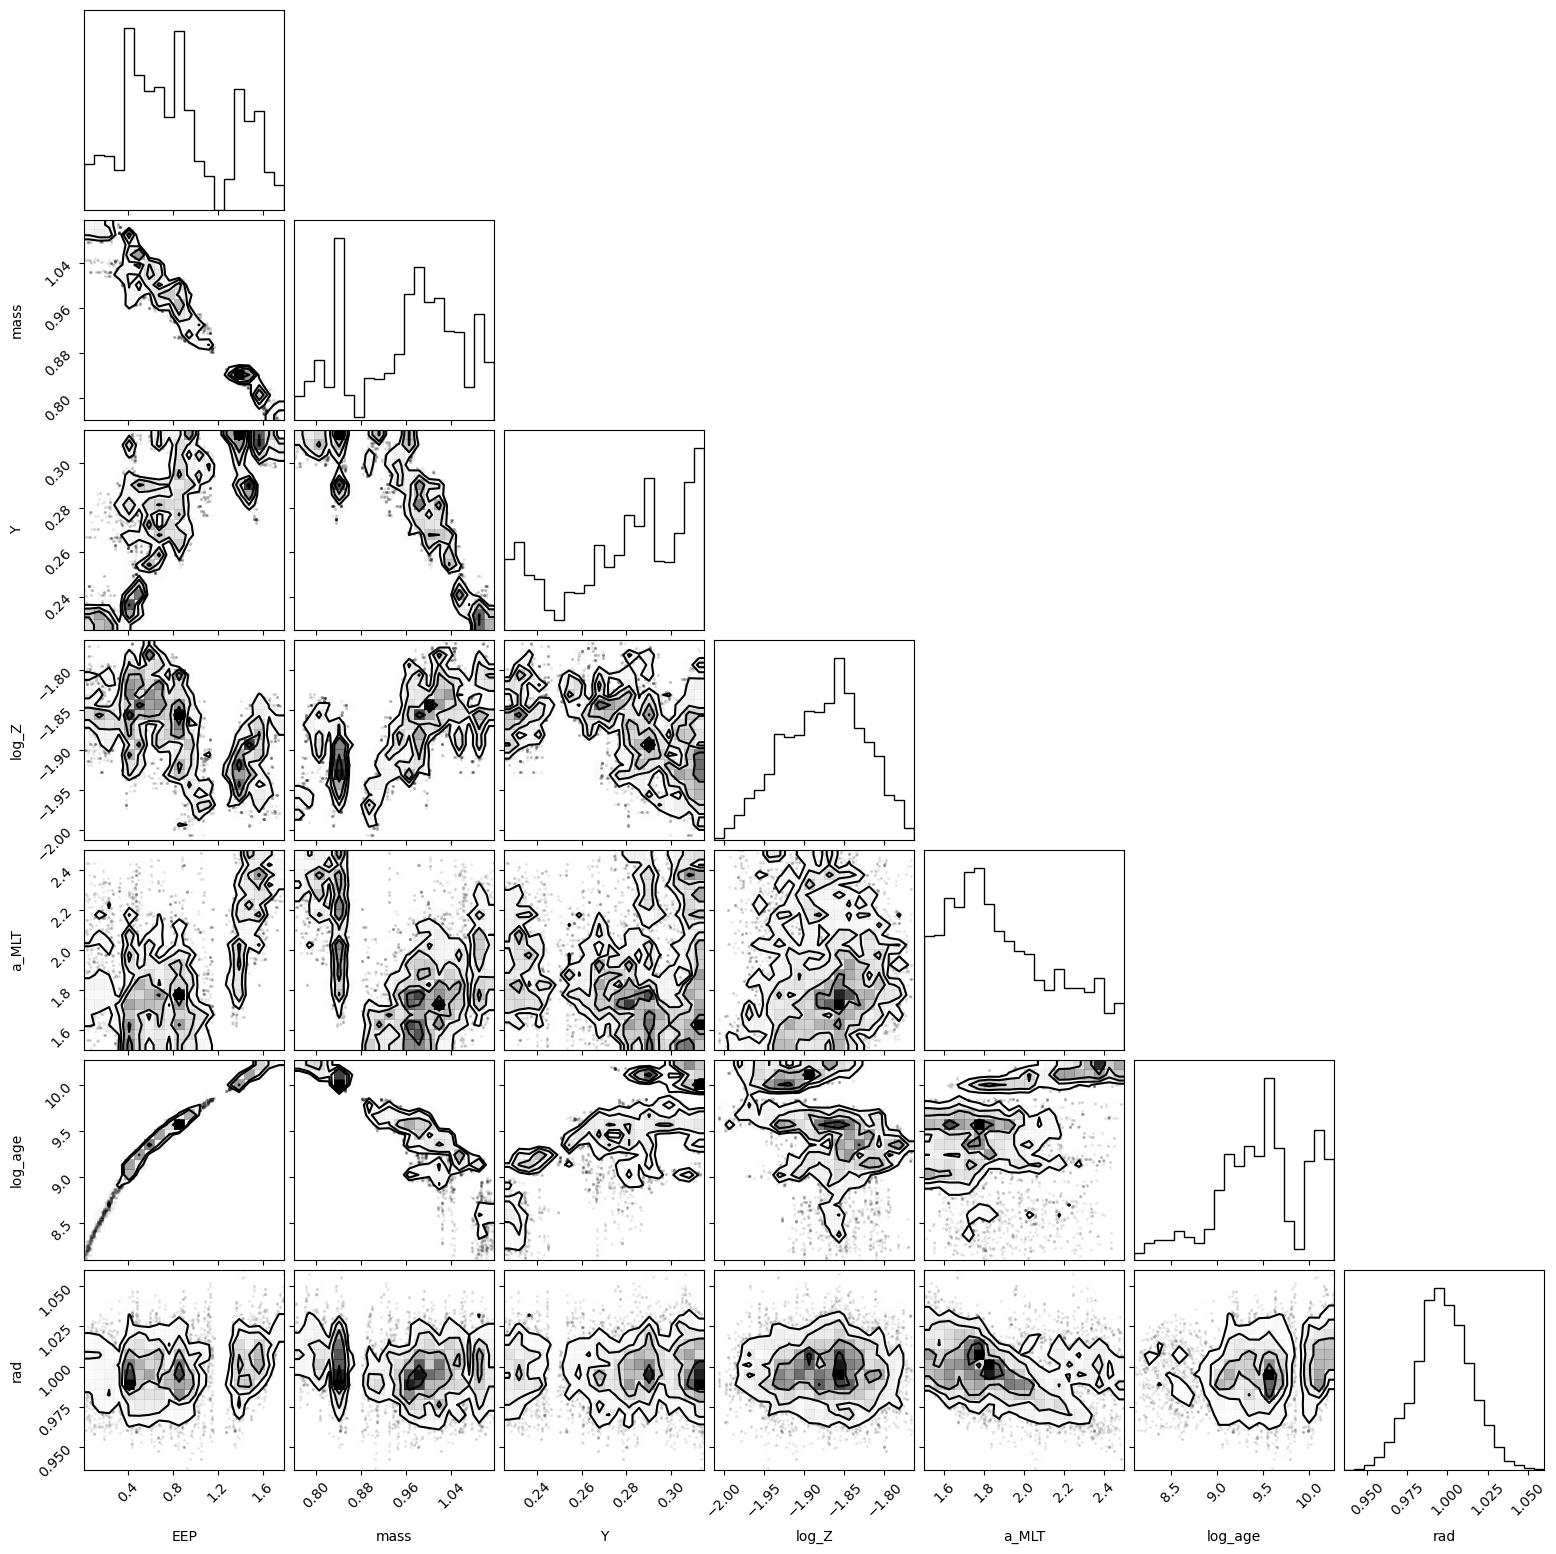

In [41]:
star = 1
var_names = ["EEP", "mass", "Y", "log_Z", "a_MLT", "log_age", "rad"]
# true_values = {k: v[star] for k, v in truth.items()}
fig = corner(data, group="posterior", var_names=var_names, coords={"star": star}, truths=true_values, divergences=True)

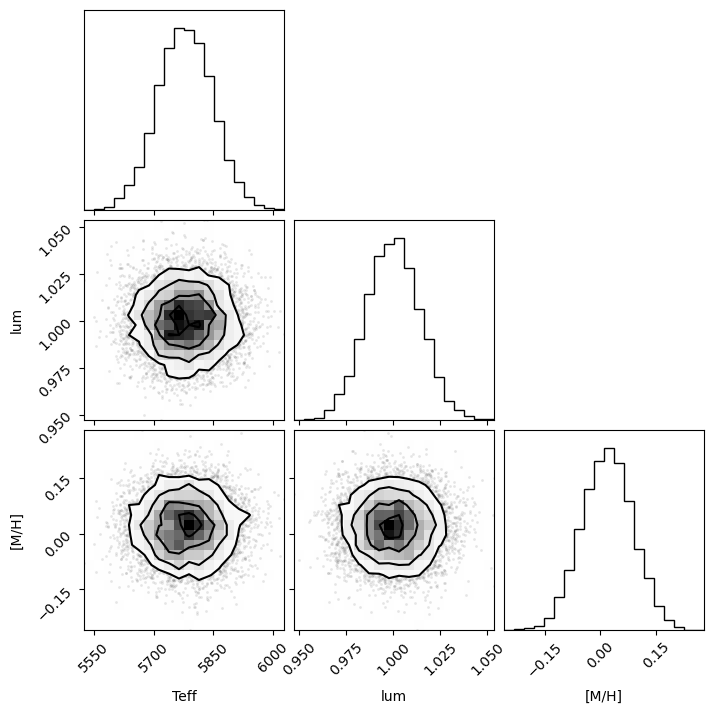

In [42]:
star = 1
var_names = ["Teff", "lum", "[M/H]"]
# true_values = {k: v[star] for k, v in truth.items()}
fig = corner(data, group="posterior_predictive", var_names=var_names, coords={"star": star}, truths=true_values, divergences=True)

## To Do

- Better priors
- Assume we already know some stuff about the stars
- E.g. mass from mass-luminosity reltaion
- Or, mass from scaling relation
- Or, something else